<a href="https://colab.research.google.com/github/ruchithareddy058/Edge-Computing/blob/master/Edge_Computing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ruchithareddy058/Edge-Computing.git

In [ ]:
%cd Edge-Computing

In [ ]:
!gdown https://drive.google.com/uc?id=188COTDT1ILKMOHyNnX74yxIdNIw2xKH1
!unzip models.zip

In [ ]:
!gdown https://drive.google.com/uc?id=1sERz6qTmy6Y5CsCIBqe615elao4zlD7h
!unzip AdienceBenchmarkGenderAndAgeClassification.zip

In [6]:
import pandas as pd 
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img

In [7]:
data = pd.read_csv("AdienceBenchmarkGenderAndAgeClassification/fold_0_data.txt",sep = "\t" )
data1 = pd.read_csv("AdienceBenchmarkGenderAndAgeClassification/fold_1_data.txt",sep = "\t")
data2 = pd.read_csv("AdienceBenchmarkGenderAndAgeClassification/fold_2_data.txt",sep = "\t")
data3 = pd.read_csv("AdienceBenchmarkGenderAndAgeClassification/fold_3_data.txt",sep = "\t")
data4 = pd.read_csv("AdienceBenchmarkGenderAndAgeClassification/fold_4_data.txt",sep = "\t")

In [ ]:
data.shape
total_shape = (data.shape[0]+data1.shape[0]+data2.shape[0]+data3.shape[0]+data4.shape[0],data.shape[1])
print(data4.shape)
print(total_shape)


In [ ]:
data.columns

In [ ]:
data.dtypes

In [ ]:
data.describe()

In [ ]:
data.head(10)

In [ ]:
plt.figure(1, figsize=(8,8))
data.age.value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

In [ ]:
gender = ['f','m','u']
plt.bar(gender,data.gender.value_counts(), align='center', alpha=0.5)
plt.show()

In [ ]:
path = "AdienceBenchmarkGenderAndAgeClassification/faces/39411334@N02/coarse_tilt_aligned_face.413.11043842734_2ac635d831_o.jpg"
img = load_img(path)
plt.imshow(img)
plt.show()

In [20]:
import cv2 as cv
import math
import time
from google.colab.patches import cv2_imshow

In [21]:
def getFaceBox(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes

faceProto = "models/opencv_face_detector.pbtxt"
faceModel = "models/opencv_face_detector_uint8.pb"

ageProto = "models/age_deploy.prototxt"
ageModel = "models/age_net.caffemodel"

genderProto = "models/gender_deploy.prototxt"
genderModel = "models/gender_net.caffemodel"

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']

# Load network
ageNet = cv.dnn.readNet(ageModel, ageProto)
genderNet = cv.dnn.readNet(genderModel, genderProto)
faceNet = cv.dnn.readNet(faceModel, faceProto)

padding = 20

def age_gender_detector(frame):
    # Read frame
    t = time.time()
    frameFace, bboxes = getFaceBox(faceNet, frame)
    for bbox in bboxes:
        # print(bbox)
        face = frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding, frame.shape[1]-1)]

        blob = cv.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]

        label = "{},{}".format(gender, age)
        cv.putText(frameFace, label, (bbox[0], bbox[1]-10), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv.LINE_AA)
    return frameFace

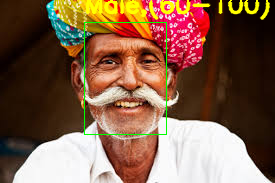

In [22]:
input=cv.imread("image10.jpg")
output=age_gender_detector(input)
cv2_imshow(output)

In [ ]:
input=cv.imread("AdienceBenchmarkGenderAndAgeClassification/faces/98075207@N04/coarse_tilt_aligned_face.1688.9660070286_4901dbedd9_o.jpg")
output=age_gender_detector(input)
cv2_imshow(output)

In [ ]:
input=cv.imread("AdienceBenchmarkGenderAndAgeClassification/faces/98075207@N04/coarse_tilt_aligned_face.1702.9660265520_6f74bb498b_o.jpg")
output=age_gender_detector(input)
cv2_imshow(output)

In [ ]:
input=cv.imread("AdienceBenchmarkGenderAndAgeClassification/faces/9017386@N06/coarse_tilt_aligned_face.207.10770684434_d85338d851_o.jpg")
output=age_gender_detector(input)
cv2_imshow(output)

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
input = cv.imread("photo.jpg")
output = age_gender_detector(input)
cv2_imshow(output)